# Installing requirements

In [1]:
dataset_path = 'dataset.json'
batch_dataset_path = 'batch_dataset.json'

In [2]:
!pip install huggingface_hub
!pip install datasets
!pip install scikit-learn
!pip install matplotlib

from pathlib import Path
from huggingface_hub import notebook_login
import datasets
import warnings
from tqdm import tqdm, TqdmWarning
warnings.filterwarnings('ignore', category = TqdmWarning)
import numpy as np
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
import random
import matplotlib.pyplot as plt
import matplotlib.colors as colors

You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# Download the dataset

In [3]:
if Path(dataset_path).exists() :
    dataset = pd.read_json(dataset_path)
else :
    notebook_login()
    hugging_face_dataset = datasets.load_dataset('lmsys/chatbot_arena_conversations')
    dataset = hugging_face_dataset['train'].to_pandas()
    dataset.to_json(dataset_path)

In [4]:
dataset[dataset['turn'] > 3][:1]

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn,anony,language,tstamp,openai_moderation,toxic_chat_tag
33,8120899314f74641b09c2aa114d4d253,alpaca-13b,vicuna-13b,model_b,arena_user_316,[{'content': 'Salut ! Comment ça va ce matin ?...,[{'content': 'Salut ! Comment ça va ce matin ?...,6,True,French,1.682354e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil..."


# Create text-author pairs

In [5]:
# Initialize an empty list for processed data
text_author_pairs = []

# Iterate through each row of the DataFrame
for _, row in dataset.iterrows():
    # Process conversation_a (assistant role)
    for message in row["conversation_a"]:
        if message["role"] == "assistant":
            text_author_pairs.append({
                "text": message["content"],
                "author": row["model_a"]
            })

    # Process conversation_b (assistant role)
    for message in row["conversation_b"]:
        if message["role"] == "assistant":
            text_author_pairs.append({
                "text": message["content"],
                "author": row["model_b"]
            })

    # Process user messages (common across both conversations)
    for message in row["conversation_a"]:  # Check only `conversation_a` since user messages are identical
        if message["role"] == "user":
            text_author_pairs.append({
                "text": message["content"],
                "author": "human"
            })

# Create token count vectors for each text

In [6]:
# Extract texts and their authors
texts = [entry['text'] for entry in text_author_pairs]
authors = [entry['author'] for entry in text_author_pairs]

# Vectorize the paragraphs
vectoriser = CountVectorizer()
text_vectors = vectoriser.fit_transform(texts)  # Each row is a text

# Allocate quotas for each batch.
batch_count = {} 
for author in list(set(authors)) :
    # Find out how many batches of 200 texts are needed.
    number_of_batches = round(authors.count(author) / 200)
    for i in range(number_of_batches) :
        # Distribute the remainder/shortfall evenly.
        batch_count[str(i) + '_' + author] = np.floor((i + 1) * authors.count(author) / number_of_batches)
        for j in range(i) :
            # Subtract the count of previous batches.
            batch_count[str(i) + '_' + author] -= batch_count[str(j) + '_' + author]
        
print('Populating batches...')
batch_vectors = {}
batch_quota = batch_count.copy()
for i, author in enumerate(tqdm(authors)):
    batch_to_insert = [name for name in batch_quota if author in name and batch_quota[name] > 0][0]
    if batch_to_insert in batch_vectors:
        # The resulting vectors represent the number of times each token appears in that author's entire corpus.
        batch_vectors[batch_to_insert] += text_vectors[i].toarray()
    else:
        # Add this new batch to the list.
        batch_vectors[batch_to_insert] = text_vectors[i].toarray()
    batch_quota[batch_to_insert] -= 1

# Convert to a dataframe
print('Converting into DataFrame...')
batch_dataset = pd.DataFrame({name: vector.flatten() for name, vector in tqdm(batch_vectors.items())}, index = vectoriser.get_feature_names_out())

batch_dataset

Populating batches...


100%|████████████████████████████████████████████████████████████████████████| 117948/117948 [01:14<00:00, 1590.37it/s]


Converting into DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 591/591 [00:00<00:00, 2661.58it/s]


,0_chatglm-6b,0_koala-13b,0_human,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_human,...,190_human,191_human,192_human,6_wizardlm-13b,193_human,6_gpt4all-13b-snoozy,5_guanaco-33b,194_human,195_human,196_human
00,0,0,0,0,8,3,1,0,1,3,...,0,0,0,3,0,0,0,0,0,2
000,3,1,0,4,0,2,4,0,0,0,...,0,0,3,6,0,3,0,7,2,0
0000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000000,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｔｏ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ｗｅｅｋｓ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝘀𝗶𝗺𝗽𝗹𝗲,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Group texts by author

In [7]:
# Find the average text length of each author. 
batch_average_length = {name: np.sum(vector) / batch_count[name] for name, vector in batch_vectors.items()}

# Normalise the length of each corpus.
print('Normalising...')
for name in tqdm(batch_vectors) :
    batch_dataset[name] /= np.sum(batch_vectors[name])
    
# Since it has been lost, add the average text length as a separate feature.
batch_dataset = pd.concat([batch_dataset, pd.DataFrame(batch_average_length, index = [' length'])])

batch_dataset

Normalising...


100%|████████████████████████████████████████████████████████████████████████████████| 591/591 [01:06<00:00,  8.84it/s]


,0_chatglm-6b,0_koala-13b,0_human,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_human,...,190_human,191_human,192_human,6_wizardlm-13b,193_human,6_gpt4all-13b-snoozy,5_guanaco-33b,194_human,195_human,196_human
00,0.000000,0.000000,0.000000,0.000000,0.000926,0.000135,0.000083,0.000000,0.000095,0.000755,...,0.00,0.000,0.000000,0.000124,0.000,0.000000,0.000000,0.000000,0.000000,0.000241
000,0.000095,0.000041,0.000000,0.000201,0.000000,0.000090,0.000331,0.000000,0.000000,0.000000,...,0.00,0.000,0.000619,0.000248,0.000,0.000157,0.000000,0.000939,0.000454,0.000000
0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
000000,0.000000,0.000082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｗｅｅｋｓ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻𝘀,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
batch_dataset.to_json(batch_dataset_path)

# Custom holdout

In [29]:
def holdout(df, authors, seed) :
    random.seed(seed)
    
    holdout_list = []
    for author in authors :
        batch = df[random.choice([batch for batch in df.columns if author in batch])].copy()
        holdout_list.append(batch)

    holdout_df = pd.concat(holdout_list, axis = 1)
    training_df = df.drop(columns = holdout_df.columns).copy()
    return training_df, holdout_df

# Use the function for this seed 0 run.
training_dataset, holdout_dataset = holdout(batch_dataset, list(set(authors)), 0)
training_dataset

,0_chatglm-6b,0_koala-13b,0_human,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_human,...,4_guanaco-33b,5_gpt4all-13b-snoozy,190_human,191_human,192_human,193_human,5_guanaco-33b,194_human,195_human,196_human
00,0.000000,0.000000,0.000000,0.000000,0.000926,0.000135,0.000083,0.000000,0.000095,0.000755,...,0.000000,0.001538,0.00,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000241
000,0.000095,0.000041,0.000000,0.000201,0.000000,0.000090,0.000331,0.000000,0.000000,0.000000,...,0.000176,0.000228,0.00,0.000,0.000619,0.000,0.000000,0.000939,0.000454,0.000000
0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000627,0.00,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
000000,0.000000,0.000082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｗｅｅｋｓ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻𝘀,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


# Feature selection

In [30]:
def common_tokens(dataset, holdout_dataset) :
    human_dataset = dataset[[name for name in dataset.columns if 'human' in name]].copy()
    llm_dataset = dataset[[name for name in dataset.columns if not 'human' in name]].copy()
    dataset = pd.merge(llm_dataset[llm_dataset.ne(0).sum(axis=1) == llm_dataset.shape[1]], human_dataset, left_index=True, right_index=True, validate='1:1')
    holdout_dataset = holdout_dataset.loc[dataset.index].copy()
    return dataset, holdout_dataset

training_dataset, holdout_dataset = common_tokens(training_dataset, holdout_dataset)
training_dataset

,0_chatglm-6b,0_koala-13b,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_vicuna-13b,1_koala-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
10,0.000698,0.000945,0.000705,0.000463,0.000630,0.000994,0.000687,0.001040,0.000472,0.000806,...,0.001238,0.000262,0.001459,0.001037,0.001772,0.001856,0.002592,0.001610,0.000227,0.000481
about,0.001776,0.001068,0.001309,0.000810,0.002116,0.001160,0.003070,0.002459,0.001769,0.002110,...,0.001856,0.003148,0.005209,0.005965,0.002658,0.005568,0.003672,0.004428,0.002496,0.001443
after,0.000317,0.000205,0.000554,0.000231,0.000180,0.000580,0.000404,0.000095,0.000708,0.000345,...,0.000619,0.000262,0.000417,0.000259,0.001624,0.000825,0.000864,0.005233,0.000227,0.000601
all,0.001237,0.001068,0.001107,0.001620,0.000856,0.000994,0.002101,0.001797,0.000708,0.001189,...,0.003249,0.001574,0.001459,0.002075,0.002805,0.002475,0.002592,0.002147,0.001815,0.000241
also,0.003075,0.002998,0.002718,0.004165,0.003062,0.002486,0.002747,0.002838,0.002713,0.003108,...,0.000309,0.001049,0.000417,0.000259,0.000886,0.000412,0.001080,0.001342,0.000908,0.000241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
world,0.000919,0.001027,0.000856,0.001620,0.001396,0.000994,0.001656,0.002459,0.001455,0.001650,...,0.000464,0.000787,0.000417,0.000259,0.000000,0.000825,0.001944,0.000000,0.000681,0.000361
would,0.000476,0.001930,0.001057,0.003008,0.001891,0.001740,0.002141,0.001419,0.001455,0.001919,...,0.001238,0.001049,0.003751,0.003112,0.002362,0.003300,0.001080,0.001476,0.002042,0.000722
you,0.009480,0.010103,0.012080,0.010066,0.008240,0.010108,0.013492,0.013432,0.008965,0.009247,...,0.008199,0.017576,0.012294,0.013485,0.005758,0.016498,0.013610,0.013149,0.010211,0.003007
your,0.003234,0.004271,0.006845,0.003587,0.004233,0.002900,0.004039,0.003689,0.003146,0.005986,...,0.001547,0.002099,0.003126,0.002334,0.002658,0.003300,0.006697,0.002549,0.003177,0.000962


# Centring

In [31]:
def centre(dataset, holdout_dataset) :
    features_mean = pd.Series({feature: np.mean(dataset.loc[feature]) for feature in dataset.index})
    for batch in dataset.columns :
        dataset[batch] -= features_mean
    for batch in holdout_dataset.columns :
        holdout_dataset[batch] -= features_mean
    return dataset, holdout_dataset
    
training_dataset, holdout_dataset = centre(training_dataset, holdout_dataset)
training_dataset[training_dataset.index == ' length']

,0_chatglm-6b,0_koala-13b,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_vicuna-13b,1_koala-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
length,76.11553,39.368068,17.462264,-38.944771,29.226083,-20.160437,39.573807,-29.251304,44.778068,47.933068,...,-49.89452,-63.316932,-58.261354,-63.096932,-48.511932,-58.010098,-59.231932,-44.924671,-60.341932,-40.806932


# Standardisation

In [32]:
def standardise(dataset, holdout_dataset) :
    features_std = pd.Series({feature: np.std(dataset.loc[feature]) for feature in dataset.index})
    for batch in dataset.columns :
        dataset[batch] /= features_std
    for batch in holdout_dataset.columns :
        holdout_dataset[batch] /= features_std
    return dataset, holdout_dataset
    
training_dataset, holdout_dataset = standardise(training_dataset, holdout_dataset)
training_dataset[training_dataset.index == ' length']

,0_chatglm-6b,0_koala-13b,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_vicuna-13b,1_koala-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
length,1.59402,0.82445,0.365697,-0.815586,0.612056,-0.422202,0.828759,-0.612584,0.937747,1.00382,...,-1.044897,-1.32599,-1.220116,-1.321383,-1.015942,-1.214854,-1.240442,-0.940817,-1.263687,-0.854583


C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_10804\1364267143.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  feature_graph_figure.show()


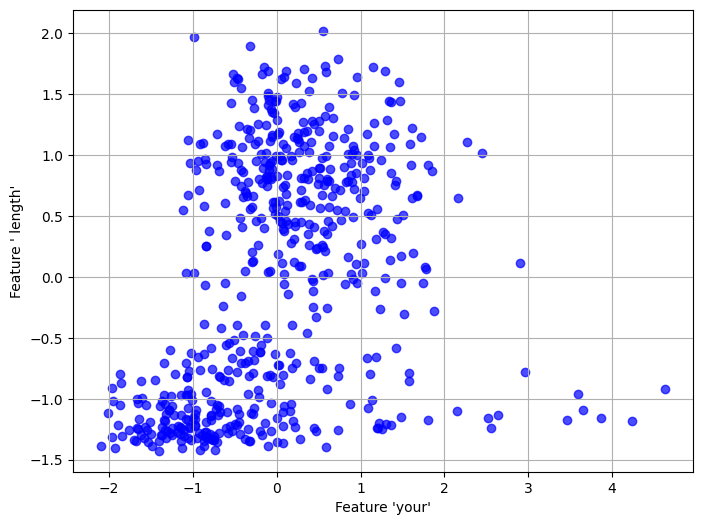

In [33]:
# Extracting the two features
x_token = training_dataset.index[-2]
y_token = training_dataset.index[-1]

# Creating the scatter plot
feature_graph_figure = plt.figure(figsize=(8, 6))
feature_graph = feature_graph_figure.subplots()
feature_graph.scatter(training_dataset.loc[x_token], training_dataset.loc[y_token], color='blue', alpha=0.7)
feature_graph.set_xlabel("Feature '" + x_token + "'")
feature_graph.set_ylabel("Feature '" + y_token + "'")
feature_graph.grid(True)
feature_graph_figure.show()

In [34]:
def power_iteration(A, num_iter=1000, tol=1e-6, single_run_diagnostics = False):
    """
    Power Iteration to compute the largest eigenvector of matrix A.
    Args:
        A (np.ndarray): Input symmetric matrix.
        num_iter (int): Number of iterations.
        tol (float): Tolerance for convergence.

    Returns:
        eigenvector (np.ndarray): Approximation of the largest eigenvector.
        eigenvalue (float): Corresponding eigenvalue.
    """
    b = np.random.rand(A.shape[1])  # Random initial vector
    b = b / np.linalg.norm(b)

    if single_run_diagnostics :
        error_meter = tqdm(position = 0, total=6, bar_format='{bar} | {postfix}')
    for i in range(num_iter):
        b_next = A @ b  # Matrix-vector multiplication
        b_next = b_next / np.linalg.norm(b_next)  # Normalize
        
        # Check for convergence
        error = np.linalg.norm(b_next - b)
        b = b_next
        if single_run_diagnostics :
            error_meter.update(min(-np.log10(error), error_meter.total) - error_meter.n)
            error_meter.set_postfix_str('{:.2E}'.format(error) + ' of error after ' + str(i + 1) + ' iterations...')
        if error < tol:
            if single_run_diagnostics :
                error_meter.close()
            break

    eigenvalue = b.T @ A @ b  # Rayleigh quotient for eigenvalue
    return b, eigenvalue

In [35]:
def pca_power_iteration(data, num_components, num_iter=2000, single_run_diagnostics = False):
    """
    PCA using Power Iteration to compute the principal components.
    Args:
        data (np.ndarray): Input data matrix (rows are samples, columns are features).
        num_components (int): Number of principal components to compute.
        num_iter (int): Number of iterations for power iteration.

    Returns:
        components (list): List of principal components (eigenvectors).
        explained_variance (list): List of corresponding eigenvalues.
    """
    covariance_matrix = np.cov(data, rowvar=True, ddof = 0)
    
    # Compute covariance matrix manually
    n = data.shape[1]  # Number of samples (columns in your case)
    covariance_matrix = (data @ data.T) / n

    components = []
    explained_variance = []

    for i in range(num_components):
        # Step 2: Compute the largest eigenvector using power iteration
        print('Computing PC' + str(i + 1) + '...')
        eigenvector, eigenvalue = power_iteration(covariance_matrix, num_iter, single_run_diagnostics)
        components.append(eigenvector)
        explained_variance.append(eigenvalue)
        
        # Step 3: Deflate the covariance matrix
        covariance_matrix -= eigenvalue * np.outer(eigenvector, eigenvector)
        if np.linalg.norm(covariance_matrix, ord='fro') < 1e-10 :
            print('Stopped as all variance has been extracted after computing ' + str(i + 1) + ' PCs.')
            break
        
    return components, explained_variance

In [36]:
components, explained_variance = pca_power_iteration(training_dataset, 50, 2000, True)

Computing PC1...
Computing PC2...
Computing PC3...
Computing PC4...
Computing PC5...
Computing PC6...
Computing PC7...
Computing PC8...
Computing PC9...
Computing PC10...
Computing PC11...
Computing PC12...
Computing PC13...
Computing PC14...
Computing PC15...
Computing PC16...
Computing PC17...
Computing PC18...
Computing PC19...
Computing PC20...
Computing PC21...
Computing PC22...
Computing PC23...
Computing PC24...
Computing PC25...
Computing PC26...
Computing PC27...
Computing PC28...
Computing PC29...
Computing PC30...
Computing PC31...
Computing PC32...
Computing PC33...
Computing PC34...
Computing PC35...
Computing PC36...
Computing PC37...
Computing PC38...
Computing PC39...
Computing PC40...
Computing PC41...
Computing PC42...
Computing PC43...
Computing PC44...
Computing PC45...
Computing PC46...
Computing PC47...
Computing PC48...
Computing PC49...
Computing PC50...


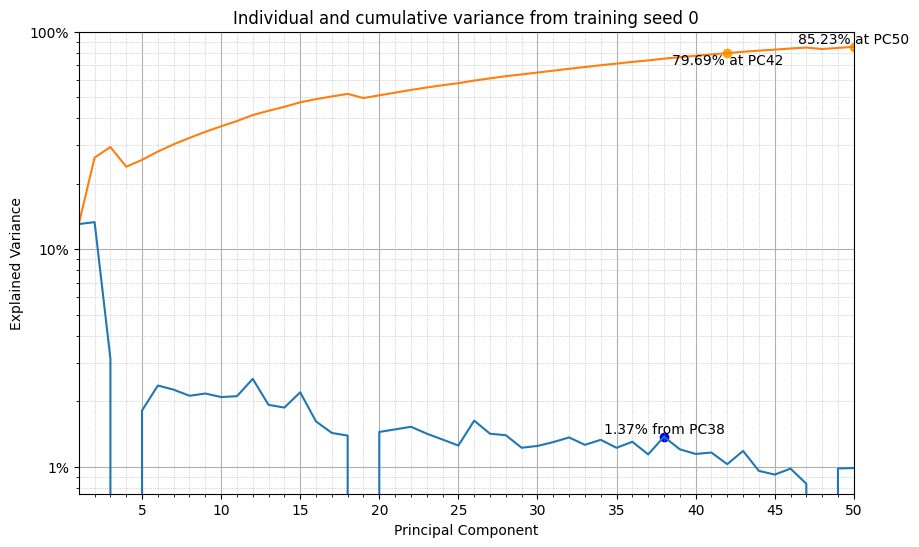

In [37]:
plt.figure(figsize=(10, 6))
plt.xticks(range(0, 51, 5))
plt.xlim(1, 50)
plt.yscale('log')
plt.ylim(0.75, 100)
plt.yticks([1, 10, 100], labels=["1%", "10%", "100%"])
plt.plot(range(1, 51), explained_variance)
plt.plot(range(1, 51), [np.sum(explained_variance[:i]) for i in range(1, 51)])

# Points of interest
plt.scatter(42, np.sum(explained_variance[:42]), color='orange')
plt.annotate('{0:.2f}'.format(np.sum(explained_variance[:42])) + '% at PC42' , (42, np.sum(explained_variance[:42])), ha = 'center', va = 'top')
plt.scatter(50, np.sum(explained_variance), color='orange')
plt.annotate('{0:.2f}'.format(np.sum(explained_variance)) + '% at PC50' , (50, np.sum(explained_variance)), ha = 'center', va = 'bottom')
plt.scatter(38, explained_variance[37], color='blue')
plt.annotate('{0:.2f}'.format(explained_variance[37]) + '% from PC38' , (38, explained_variance[37]), ha = 'center', va = 'bottom')

plt.title('Individual and cumulative variance from training seed 0')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.minorticks_on()
#plt.grid(axis = 'x', which = 'minor')
plt.grid(which='minor', axis='x', linestyle=':', linewidth=0.5)  # Minor grid lines on X-axis
plt.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)  # Minor grid lines on X-axis
plt.show()

In [38]:
def transform_to_pc(batch, components) :
    pc_space_batch = []
    for component in components :
        pc_space_batch.append(np.dot(batch, component))
        
    return pc_space_batch

C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_10804\1940050493.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  feature_graph_figure.show()


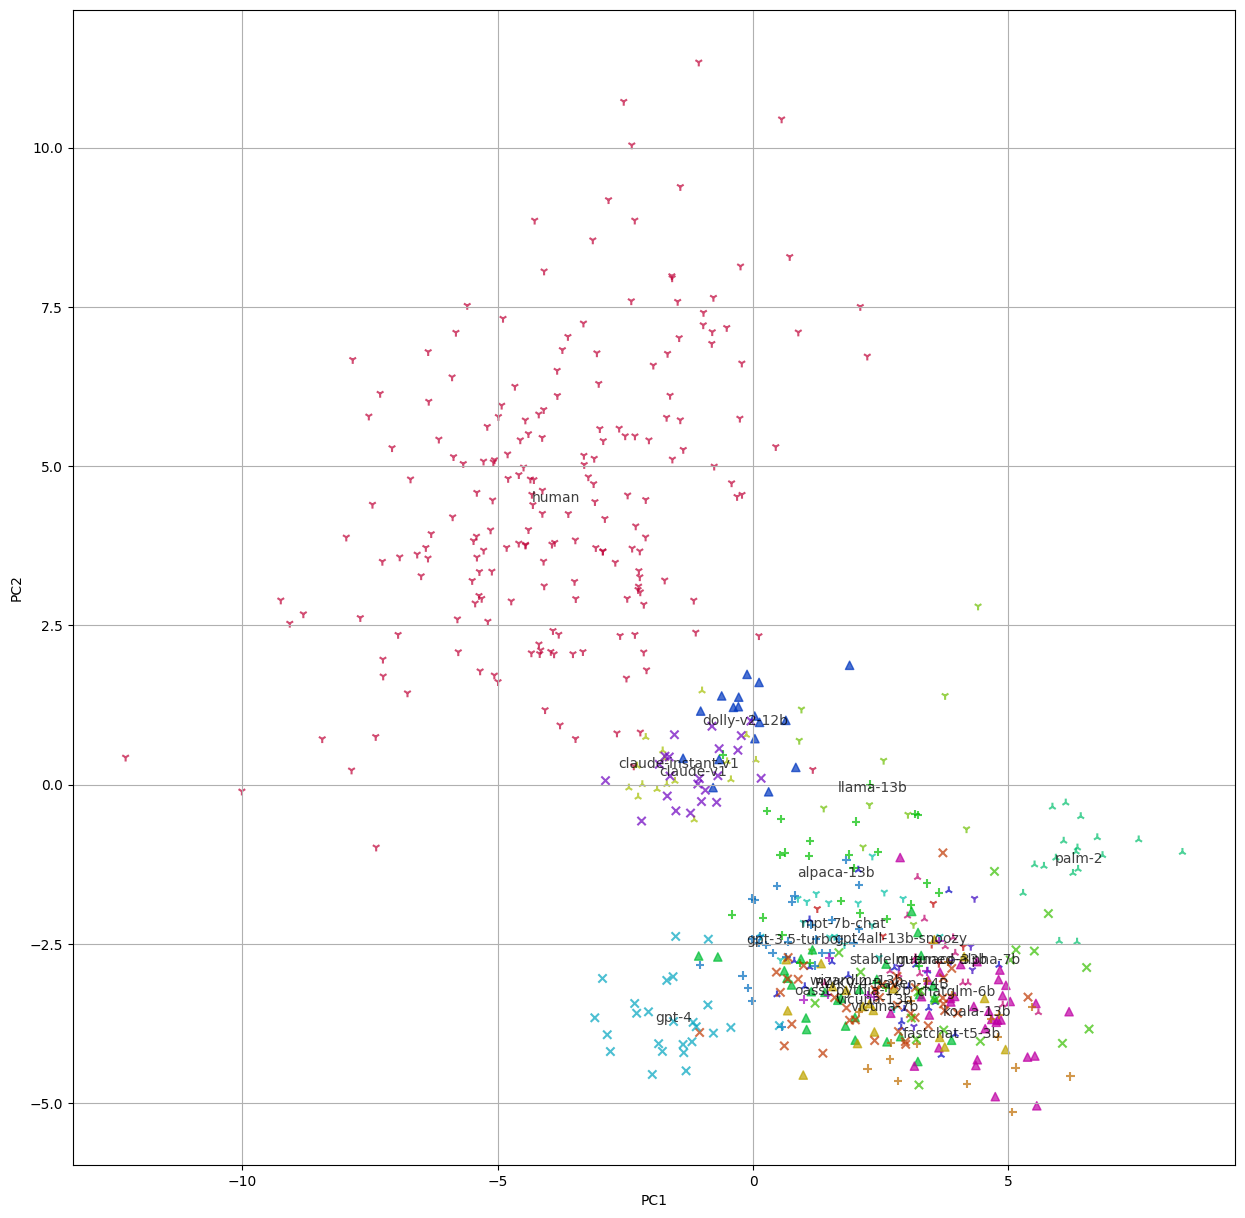

In [39]:
# Define a colour and marker shape for each author using a non-integer index; the integer part determines the shape and the decimal part the colour.
marker_list = {author: i * 5 / len(set(authors)) for i, author in enumerate(list(set(authors)))}

# Plot all training and holdout batches, but in five groups, with a shape for each.
labels = [batch.split('_')[1] for batch in training_dataset] + [batch.split('_')[1] for batch in holdout_dataset]
coords = [transform_to_pc(training_dataset[batch], components) for batch in training_dataset] + [transform_to_pc(holdout_dataset[batch], components) for batch in holdout_dataset]
coord_groups = [[] for i in range(5)]
for i in range(len(labels)) :
    coord_groups[int(marker_list[labels[i]])].append(i)

# Creating the scatter plot
feature_graph_figure = plt.figure(figsize=(15, 15))
feature_graph = feature_graph_figure.subplots()
for group, marker in enumerate(['1', '2', '^', '+', 'x']) :
    feature_graph.scatter([coords[i][0] for i in coord_groups[group]], [coords[i][1] for i in coord_groups[group]], color=[colors.hsv_to_rgb((marker_list[labels[i]] % 1, 1, 0.75)) for i in coord_groups[group]], alpha=0.7, marker = marker)
for author in list(set(authors)):
    feature_graph.annotate(author, np.mean([coords[i][:2] for i, name in enumerate(training_dataset.columns) if author in name], axis = 0), ha = 'center', va = 'center', alpha = 0.75)
feature_graph.set_xlabel("PC1")
feature_graph.set_ylabel("PC2")
feature_graph.grid(True)
feature_graph_figure.show()

In [40]:
ranking = np.argsort(components[0])
dimensions = training_dataset.index[ranking]
weights = components[0][ranking]
for i in range(len(dimensions)) :
    print(dimensions[i] + ' ' + str(weights[i]))

what -0.07309513171633444
me -0.06756631854060534
no -0.06008173386782387
how -0.060038176749890794
10 -0.04409098485020837
return -0.03729035158349265
into -0.03288782588362827
do -0.03098003489920043
should -0.01933413200564789
after -0.015308729626120133
my -0.015275620959653114
an -0.014617671448305737
like -0.009497530394437789
from -0.0062200235637575
about -0.005096627293342344
between 4.619250975871796e-05
all 0.0018040553537412639
human 0.0023362663677592927
first 0.005885104086879248
out 0.007962295106348351
when 0.008312504988237482
so 0.014567109177093631
know 0.017009508053639242
day 0.017498183042819995
most 0.018317084277559032
where 0.02199209815370644
get 0.0225672421014215
many 0.02275912680416608
without 0.024379557329450713
each 0.027517804342556827
better 0.02813065351003863
we 0.0284027542867862
just 0.03019365813697141
in 0.03583078191088338
who 0.03731939787644337
then 0.03751610150629132
best 0.039013014567324505
at 0.04061417614254493
through 0.040637038915371

# k-Nearest Neighbours

In [41]:
def k_nearest_neighbours(X_train, y_train, X_test, k = 3):
    """
    Predict labels for the test dataset.
    """
    predictions = []

    for test_point in X_test:
        # Compute distances to all training points
        distances = [np.linalg.norm(train_point - test_point) for train_point in X_train]

        k_indices = np.argsort(distances)[:k] # Find indices of k nearest neighbors
        k_labels = y_train[k_indices] # Retrieve the labels of the k nearest neighbors
        unique_labels, counts = np.unique(k_labels, return_counts=True) # Determine the most common label (majority voting)
        while np.count_nonzero(counts == np.max(counts)) != 1 : # In the event of tiebreaks, reduce k. At k = 1 a winner is guaranteed.
            k -= 1
            unique_labels, counts = np.unique(y_train[np.argsort(distances)[:k]], return_counts=True)
        
        predictions.append(unique_labels[np.argmax(counts)])
    
    return np.array(predictions)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['RWKV-4-Raven-14B' 'palm-2' 'gpt-3.5-turbo' 'koala-13b' 'human'
 'claude-v1' 'palm-2' 'guanaco-33b' 'stablelm-tuned-alpha-7b'
 'wizardlm-13b' 'vicuna-13b' 'llama-13b' 'koala-13b' 'fastchat-t5-3b'
 'RWKV-4-Raven-14B' 'gpt-3.5-turbo' 'fastchat-t5-3b' 'wizardlm-13b'
 'koala-13b' 'gpt-4' 'claude-v1']
8 out of 21


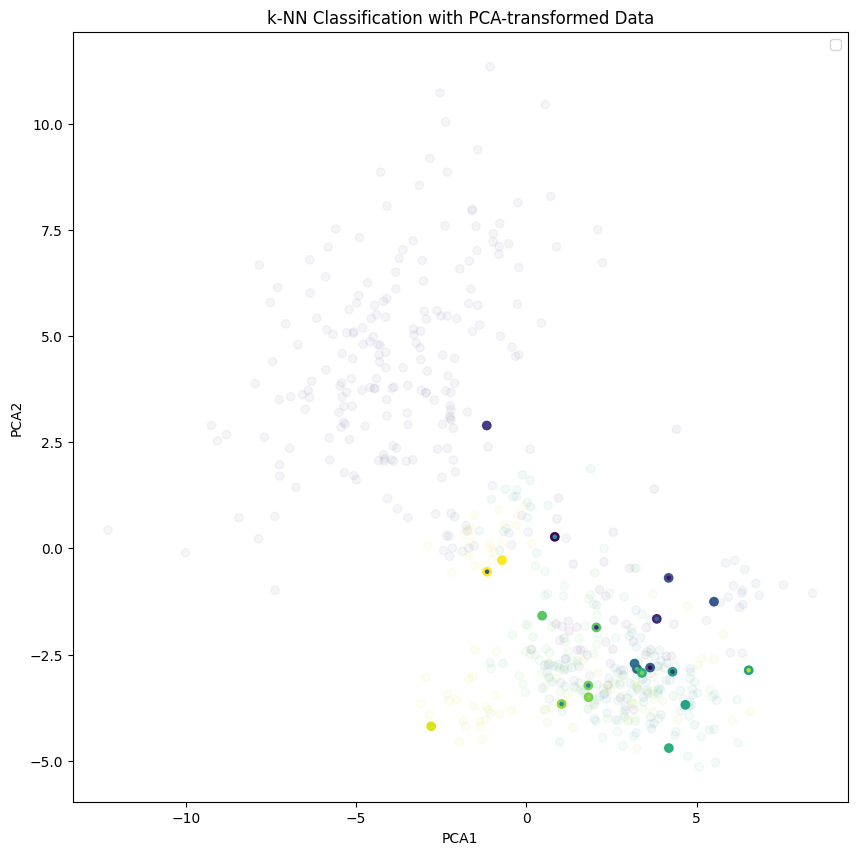

In [42]:
training_batches = np.array([transform_to_pc(training_dataset[batch], components[:10]) for batch in training_dataset])
training_labels = np.array([batch.split('_')[1] for batch in training_dataset])
testing_batches = np.array([transform_to_pc(holdout_dataset[batch], components[:10]) for batch in holdout_dataset])
testing_labels = np.array([batch.split('_')[1] for batch in holdout_dataset])

predictions = k_nearest_neighbours(training_batches, training_labels, testing_batches, 5)
print(predictions)
print(str((predictions == testing_labels).sum()) + ' out of ' + str(len(testing_labels)))

# Visualization example:
plt.figure(figsize=(10, 10))
plt.scatter([batch[0] for batch in training_batches], [batch[1] for batch in training_batches], c=[marker_list[batch.split('_')[1]] for batch in training_dataset], alpha=0.05)
plt.scatter([batch[0] for batch in testing_batches], [batch[1] for batch in testing_batches], c=[marker_list[batch] for batch in predictions])
plt.scatter([batch[0] for batch in testing_batches], [batch[1] for batch in testing_batches], c=[marker_list[batch] for batch in testing_labels], s = 5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.title('k-NN Classification with PCA-transformed Data')
plt.show()

In [ ]:
def test_suite() :
    predictions = {}  # Dictionary to store predictions for each (n, d, k) pair

    for n in range(10) :
        training_dataset, holdout_dataset = holdout(batch_dataset, list(set(authors)), n)
        training_dataset, holdout_dataset = common_tokens(training_dataset, holdout_dataset)
        training_dataset, holdout_dataset = centre(training_dataset, holdout_dataset)
        training_dataset, holdout_dataset = standardise(training_dataset, holdout_dataset)
        components, explained_variance = pca_power_iteration(training_dataset, 5)
        
        # for d in range(len(components)) :
        for d in tqdm(range(1, 6)) :
            training_batches = np.array([transform_to_pc(training_dataset[batch], components[:d]) for batch in training_dataset])
            training_labels = np.array([batch.split('_')[1] for batch in training_dataset])
            testing_batches = np.array([transform_to_pc(holdout_dataset[batch], components[:d]) for batch in holdout_dataset])
            
            for k in range(1, 5) :
                predictions[(n, d, k)] = k_nearest_neighbours(training_batches, training_labels, testing_batches, k)

    # Now construct the confusion matrix and F-score.
    testing_labels = np.array([batch.split('_')[1] for batch in holdout_dataset]) # in all runs there are a constant number of labels, in the same order

    print(type(predictions))
    return predictions

In [ ]:
predictions = test_suite()
print(type(predictions))
plt.figure(figsize=(10, 6))
for k in range(1, 25):
    predictions = [predictions[(0, d, k)] for d in range(1, 6)]
    plt.plot(range(1, 6), predictions, label=f'k={k}')

plt.xlabel('Number of Principal Components (d)')
plt.ylabel('Accuracy')
plt.title('k-NN Accuracy vs Number of Principal Components')
plt.legend()
plt.grid(True)
plt.show()